<a href="https://colab.research.google.com/github/sirsjosh/Computer-Vision/blob/main/Deformable_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the Deformable Attention Workshop!

In this workshop, we'll dive into the idea of deformable attention, and see how to:
- Build a Deformable attention module, step by step
- Integrate it in a DAT (Deformable Attention Tranformer) architecture, as in [this paper ]((https://arxiv.org/pdf/2309.01430))
- Visualize the Attention results on sample images
Sounds cool, doesn't it?
Let's take a look!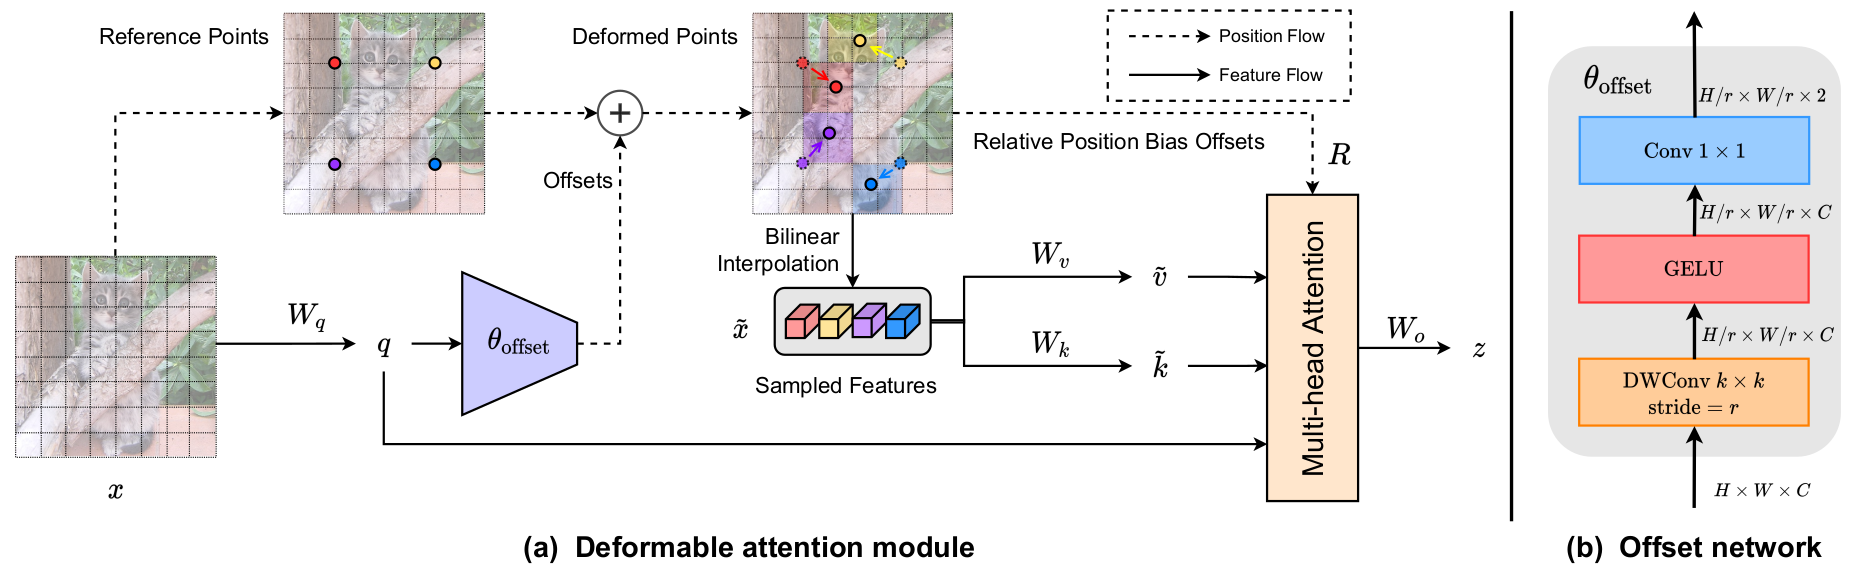

### Imports
We'll first install and import certain modules that we need

In [ ]:
!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/vit101.zip && unzip vit101.zip

--2024-06-21 07:58:20--  https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/vit101.zip
Resolving thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com (thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com)... 3.5.224.140, 16.12.19.22
Connecting to thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com (thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com)|3.5.224.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172392343 (164M) [application/zip]
Saving to: ‘vit101.zip’

vit101.zip          100%[===================>] 164.41M  29.7MB/s    in 6.3s    

2024-06-21 07:58:27 (26.1 MB/s) - ‘vit101.zip’ saved [172392343/172392343]

Archive:  vit101.zip
  inflating: Vision-Transformer-101/vision-transformer-vanilla.ipynb  
  inflating: Vision-Transformer-101/dat_blocks.py  
  inflating: Vision-Transformer-101/dat.py  
  inflating: Vision-Transformer-101/deformable-attention-transformer.ipynb  
  inflating: Vision-Transformer-101/nat.py  
  infl

In [ ]:
!pip install torch==1.11.0+cpu torchvision==0.12.0+cpu --extra-index-url https://download.pytorch.org/whl/cpu
!pip install https://shi-labs.com/natten/wheels/cpu/torch1.11/natten-0.14.6%2Btorch1110cpu-cp310-cp310-linux_x86_64.whl
!pip3 install -q einops ipympl timm

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 74.5 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.3.0+cu121
    Uninstalling torch-2.3.0+cu121:
      Successfully uninstalled torch-2.3.0+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.18.0+cu121
    Uninstalling torchvision-0.18.0+cu121:
      Successfully uninstalled torchvision-0.18.0+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.3.0+cu121 requires torch==2.3.0, but you have torch 1.11.0+cpu which is incompatible.
torchtext 0.18.0 requires torch>=2.3.0, but you have torch 1.11.0+cpu which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
os.chdir("Vision-Transformer-101")

In [ ]:
import cv2
import torch
import einops
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import trunc_normal_

This workshop is going to be in 2 big parts:
1. Deformable Attention (just the module)
2. Deformable Attention Transformer (the big architecture) & Visualization

So let's begin right away with the attention module.

## I. Deformable Attention

This module itself is going to be done in 5 parts, following the drawing below:
1. Generate **reference points**
2. Code an **offset prediction network**
3. **Sample features** using bilinear interpolation
4. Use **Multi-Head Attention**
5. Putting it all together

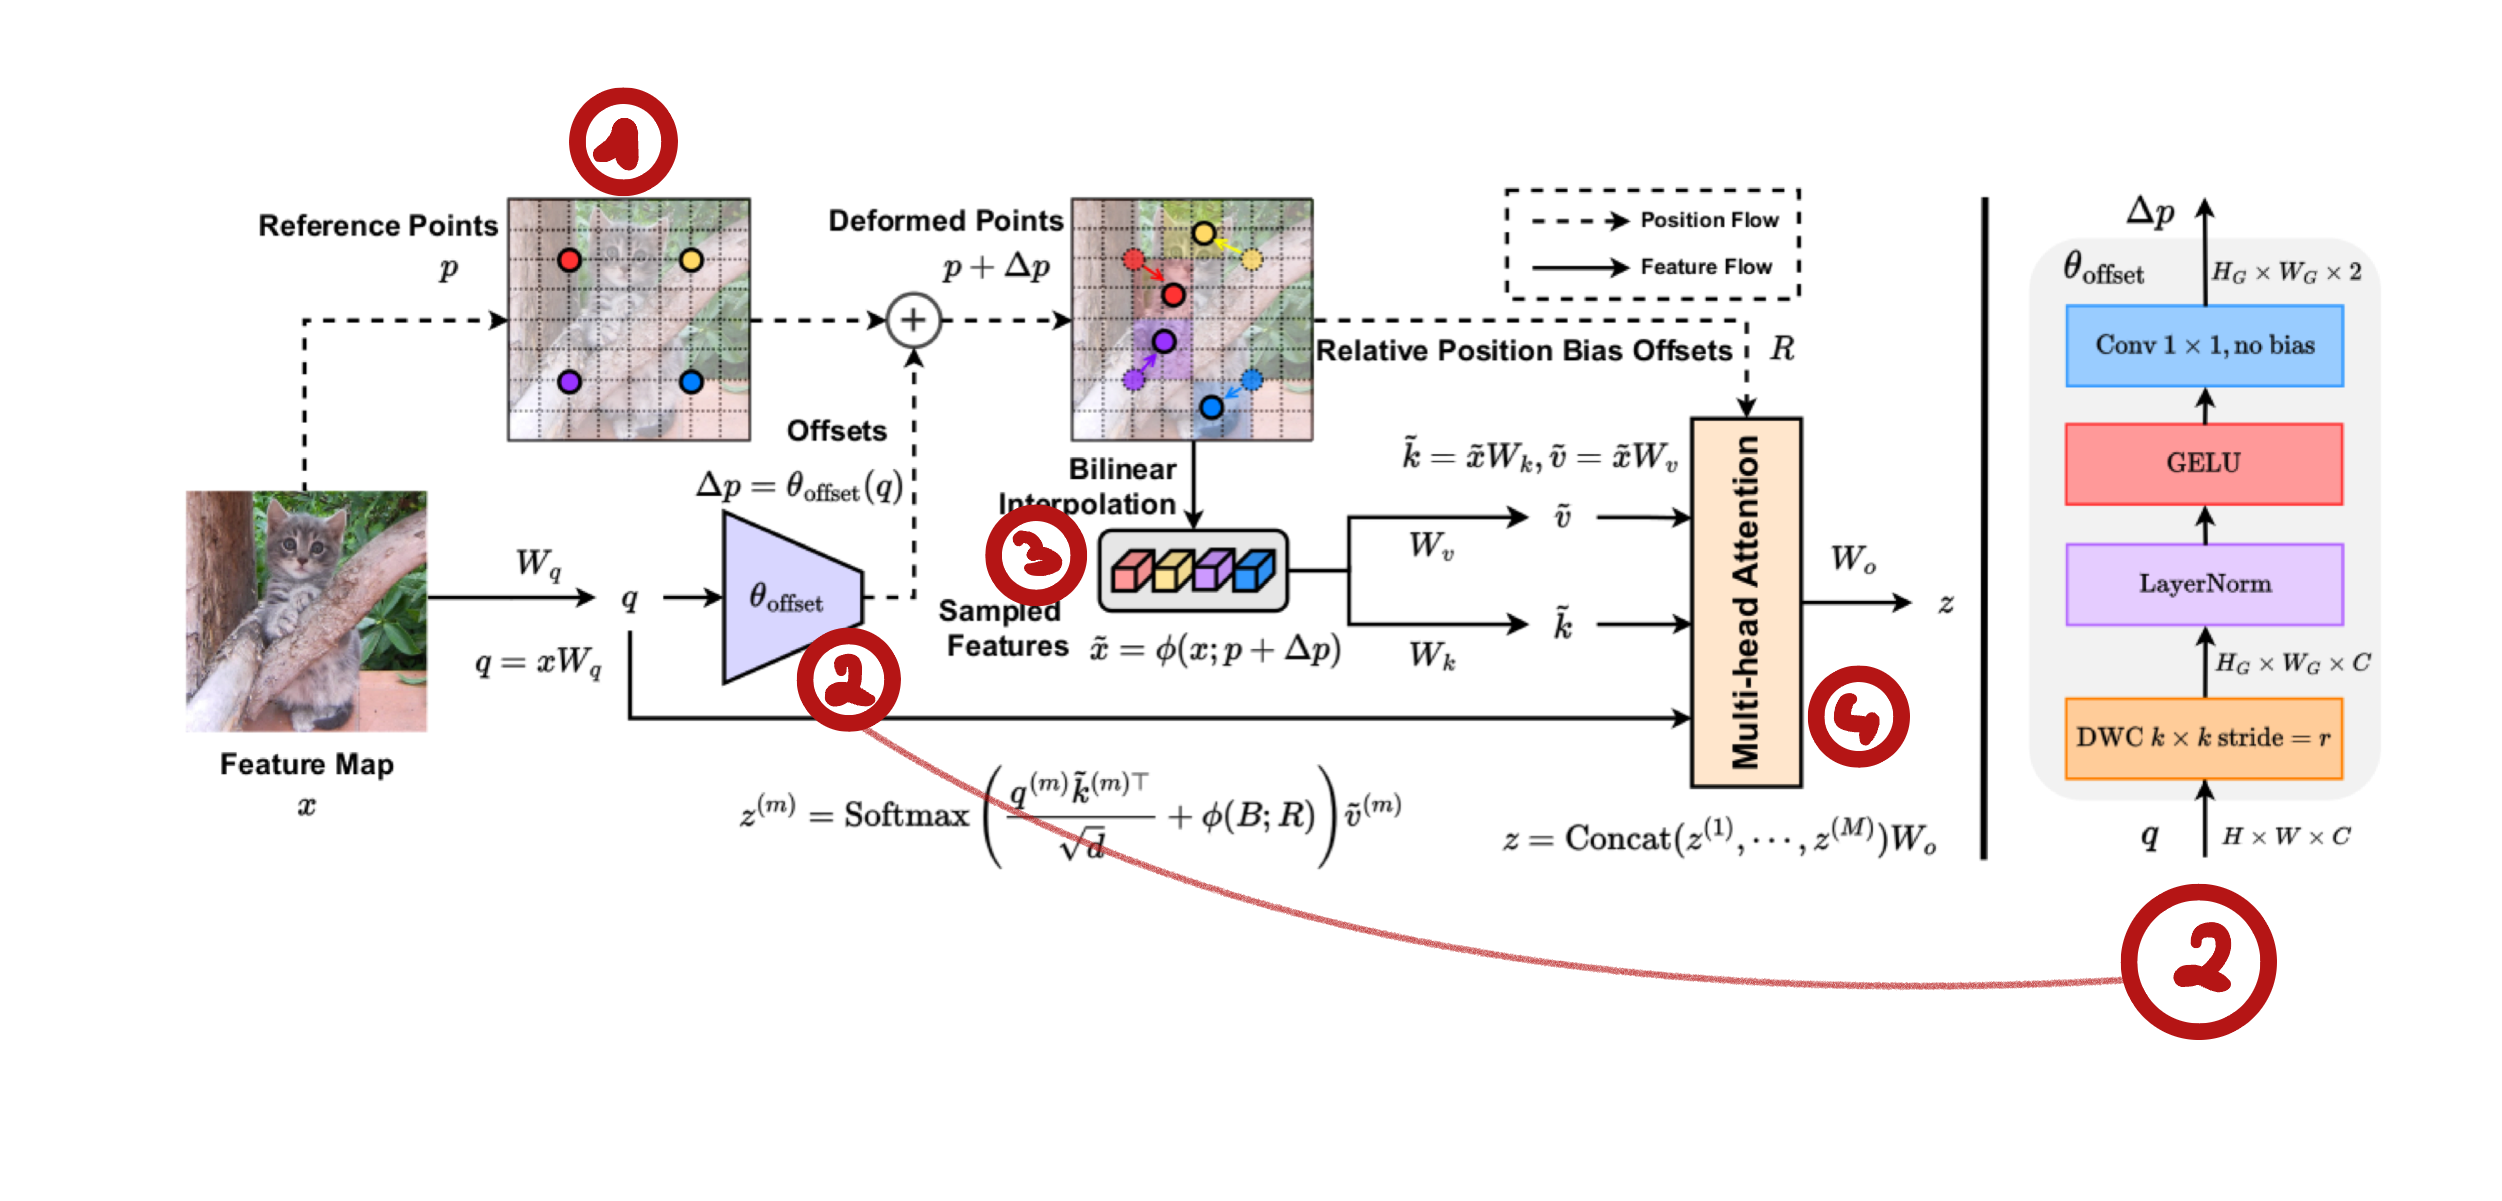

### 1. **Generate Reference Points**

The first thing we want to implement is the set of grid points, that is the same for every query (at least when defining them).
- Equally spaced 2D grid points are generated based on input feature map size. We'll make use of torch.meshgrid() function.
- Inputs
    - h_grid, w_grid, batch_size
    - n_groups
- Outputs
    - (1, batch_size, h_grid, w_grid) tensor, equally spaced points

Our reference grid is going to be uniformy sampled and then adjusted between -1 and 1.

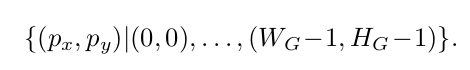

In [ ]:
bs = 1                # batch size
n_groups = 1          # depth wise convolution for efficiency

In [ ]:
def get_reference_points(h_grid, w_grid, bs, n_groups):
    ref_y, ref_x = torch.meshgrid(
        torch.linspace(0.5, h_grid - 0.5, h_grid),
        torch.linspace(0.5, w_grid - 0.5, w_grid),
        indexing='ij'
    )
    ref = torch.stack((ref_y, ref_x), -1)
    ref[..., 1].div_(w_grid - 1.0).mul_(2.0).sub_(1.0)
    ref[..., 0].div_(h_grid - 1.0).mul_(2.0).sub_(1.0)
    ref = ref[None, ...].expand(bs * n_groups, -1, -1, -1) # B * g H W 2
    ref = ref.clamp(-1.0, 1.0)
    return ref

In [ ]:
ref_grid_pts = get_reference_points(h_grid=7,  w_grid=7, bs=1, n_groups=1)
print(ref_grid_pts.shape)
ref_grid_pts_np = ref_grid_pts.detach().cpu().numpy()

torch.Size([1, 7, 7, 2])


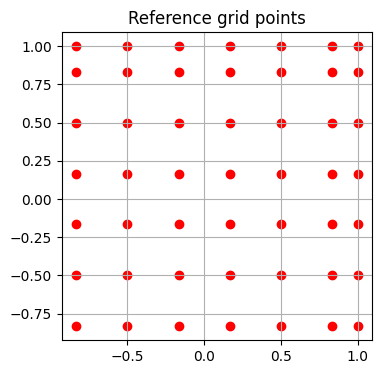

In [ ]:
plt.figure(figsize=(4,4))
for row in range(7):
    for col in range(7):
        plt.scatter(ref_grid_pts_np[0, row, col, 0], ref_grid_pts_np[0, row, col, 1], c='r', marker = 'o')
plt.title('Reference grid points')
plt.grid(True)

Awesome! We have a grid! Now the much harder part will be to create an offset prediction network. This network will do:
* A depthwise convolution
* A layer normalization operation
* A GeLU Activation
* A 1x1 Convolution

### 2. **Code an offset prediction network**

Now, you may have noticed **we're not using a real image yet**. So what is our input? Well, let's generate a dummy tensor, just for the exercise, and then use a 1x1 convolution to turn this into a feature map.

In [ ]:
# Input — Patch embedding output
test_input_data = torch.Tensor(1, 64, 56, 56)

Awesome, so our input has been put into a 56x56x64 feature map, 64 being the number of channels. Now we can use a 1x1 convolution to get a feature map of different channels, if you ever want to use a different type of attention as we're using.

In [ ]:
# Define the number of channels to be used later
n_heads = 2           # number of attention heads
n_head_channels = 32  # channel per head
nc = n_head_channels * n_heads # total channels -- 2x32 = 64

# 1x1 Convolution
proj_q = nn.Conv2d(nc, nc, kernel_size=1, stride=1, padding=0)

# Query
q = proj_q(test_input_data)
print(f"Query shape = {q.shape}")

Query shape = torch.Size([1, 64, 56, 56])


We now have a query, let's move to the Layer Norm.

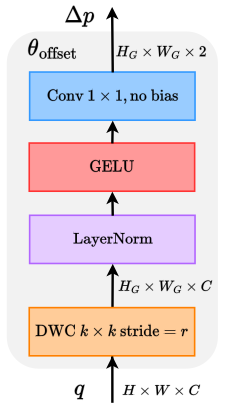

We'll first define a LayerNorm network, that accepts inputs of (bs, c, h, w) shape and outputs the same shaep, but applies a Layer Normalization inbetween.

In [ ]:
class LayerNormModule(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        x = einops.rearrange(x, 'b c h w -> b h w c')
        x = self.norm(x)
        return einops.rearrange(x, 'b h w c -> b c h w')

Now, we can finalize with the other GeLU and 1x1 final convolutin. **The Conv modules use Depth wise convolution for efficiency**. This is specified using groups parameter in PyTorch. The groups are split b/w different heads. We'll define the remaining layers as follows:

In [ ]:
ksize = 9             # kernel size for offset
stride = 8
q_size = (56, 56)     # input feature map height, width

In [ ]:
# stage 0, group channels
n_group_channels = 64

offset_generation_network = nn.Sequential(
            nn.Conv2d(n_group_channels, n_group_channels, kernel_size=ksize, stride=stride,
                      padding = ksize // 2, groups=n_group_channels), # 1, 64, 7, 7
            LayerNormModule(n_group_channels),
            nn.GELU(),
            nn.Conv2d(n_group_channels, 2, 1, 1, 0, bias=False)
        )

In [ ]:
offset = offset_generation_network(q)
print(f"offset before reshape = {offset.shape}")

# outputs have channel size of 2, we can bring it to last dimension
offset = einops.rearrange(offset, 'b p h w -> b h w p')
print(f"offset after reshape = {offset.shape}")

offset before reshape = torch.Size([1, 2, 7, 7])
offset after reshape = torch.Size([1, 7, 7, 2])


Now that we have the reference points and the offsets. So, the final position is sum of ref grid points and the calculated offset.

In [ ]:
pos = (offset + ref_grid_pts).clamp(-1., +1.)
print(pos.shape)

torch.Size([1, 7, 7, 2])


We have not trained the model yet, so the output of `pos` is totally random. Just for illustration, we'll create random points and visualize the output.

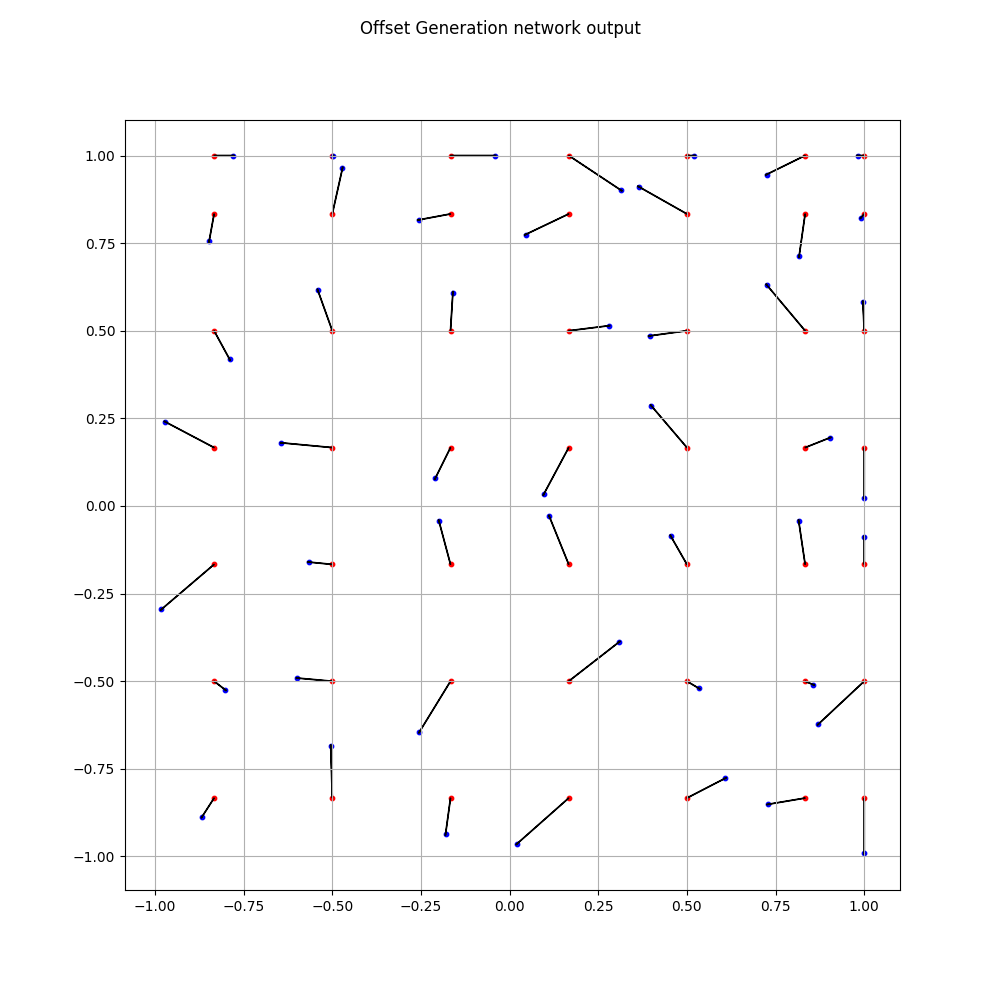

In [ ]:
# generate random offsets, 0.16 = 9 / 56, where 9 is kernel size and 56 is feature map size
random_offsets = np.random.uniform(low=-0.16, high=0.16, size=(1, 7, 7, 2))
sample_pos_np = np.clip(ref_grid_pts_np + random_offsets, -1, 1)

%matplotlib ipympl
from google.colab import output
output.enable_custom_widget_manager()

plt.figure(figsize = (10,10))
plt.suptitle('Offset Generation network output')
plt.grid(True)

for row in range(7):
    for col in range(7):
        # add reference points and the deformed points
        s1 = plt.scatter(ref_grid_pts_np[0, row, col, 0], ref_grid_pts_np[0, row, col, 1], s= 10, c='r')
        s2 = plt.scatter(sample_pos_np[0, row, col, 0], sample_pos_np[0, row, col, 1], s= 10, c='b')

        # plot a line from reference point to deformed point
        dx = sample_pos_np[0, row, col, 0] - ref_grid_pts_np[0, row, col, 0]
        dy = sample_pos_np[0, row, col, 1] - ref_grid_pts_np[0, row, col, 1]
        plt.arrow(ref_grid_pts_np[0, row, col, 0], ref_grid_pts_np[0, row, col, 1], dx, dy)

### 3. **Sample Features using bilinear interpolation**

Our input feature map is of size (56, 56), but we only need features at the location of the deformed points. **This is why we're using the sampling, to get values at the location of the 7x7 deformed points within the feature map.**

We'll do this using PyTorch's [grid sampling](https://pytorch.org/docs/stable/generated/torch.nn.functional.grid_sample.html) function.

In [ ]:
sampled_features = F.grid_sample(
    input=test_input_data, grid=pos[..., (1, 0)], # y, x -> x, y
    mode='bilinear', align_corners=True) # B * g, Cg, Hg, Wg

# flatten the height width dimension
sampled_features = einops.rearrange(sampled_features, 'g c h w -> g c 1 (h w)')
print(f"Sampled_features shape = {sampled_features.shape}")

Sampled_features shape = torch.Size([1, 64, 1, 49])


### RECAP! ⚠️
We have:
1. Defined a grid of uniformly sampled points
2. Calculated a 2D offset value (x,y) for each point
3. Used bilinear interpolation to get features at each deformed point.

We'll now go to 4) and calculate the attention for each input patch (56x56) in relationship with each of the 49 points.<P>

**Is this more efficient?**<P>
Yes! Because in the original transformer, we're calculating (56x56)x(56x56) ~10M computations, and now we're calculating (56x56)x(7x7) ~150k computations.


### 4. Use **Multi-Head Attention**

We're now ready for MHA... or almost! There are a few elements we need to prepare. In particular, we want to set the right number of heads (and multiply the QKV accordingly), we want to get the right shapes, and do the maths!

In [ ]:
proj_k = nn.Conv2d(nc, nc, kernel_size=1, stride=1, padding=0)
k = proj_k(sampled_features)
print(f"Key shape = {k.shape}")

Key shape = torch.Size([1, 64, 1, 49])


#### A — Preparing Query & Key for Multi-Head Attention
Let's take a look at what we have already:
* **Input Tensor** (test_input_data): Shape [1, 64, 56, 56]
    * This basically means, we have a batch of feature maps of size 56x56x64 each
* **Query Shape**: [1, 64, 56, 56]
* **Key Shape**: [1, 64, 1, 49]
The Query & Key don't look like they can be multiplied yet... And this because the key is coming from the samples features, so it's of size 7x7 = 49...

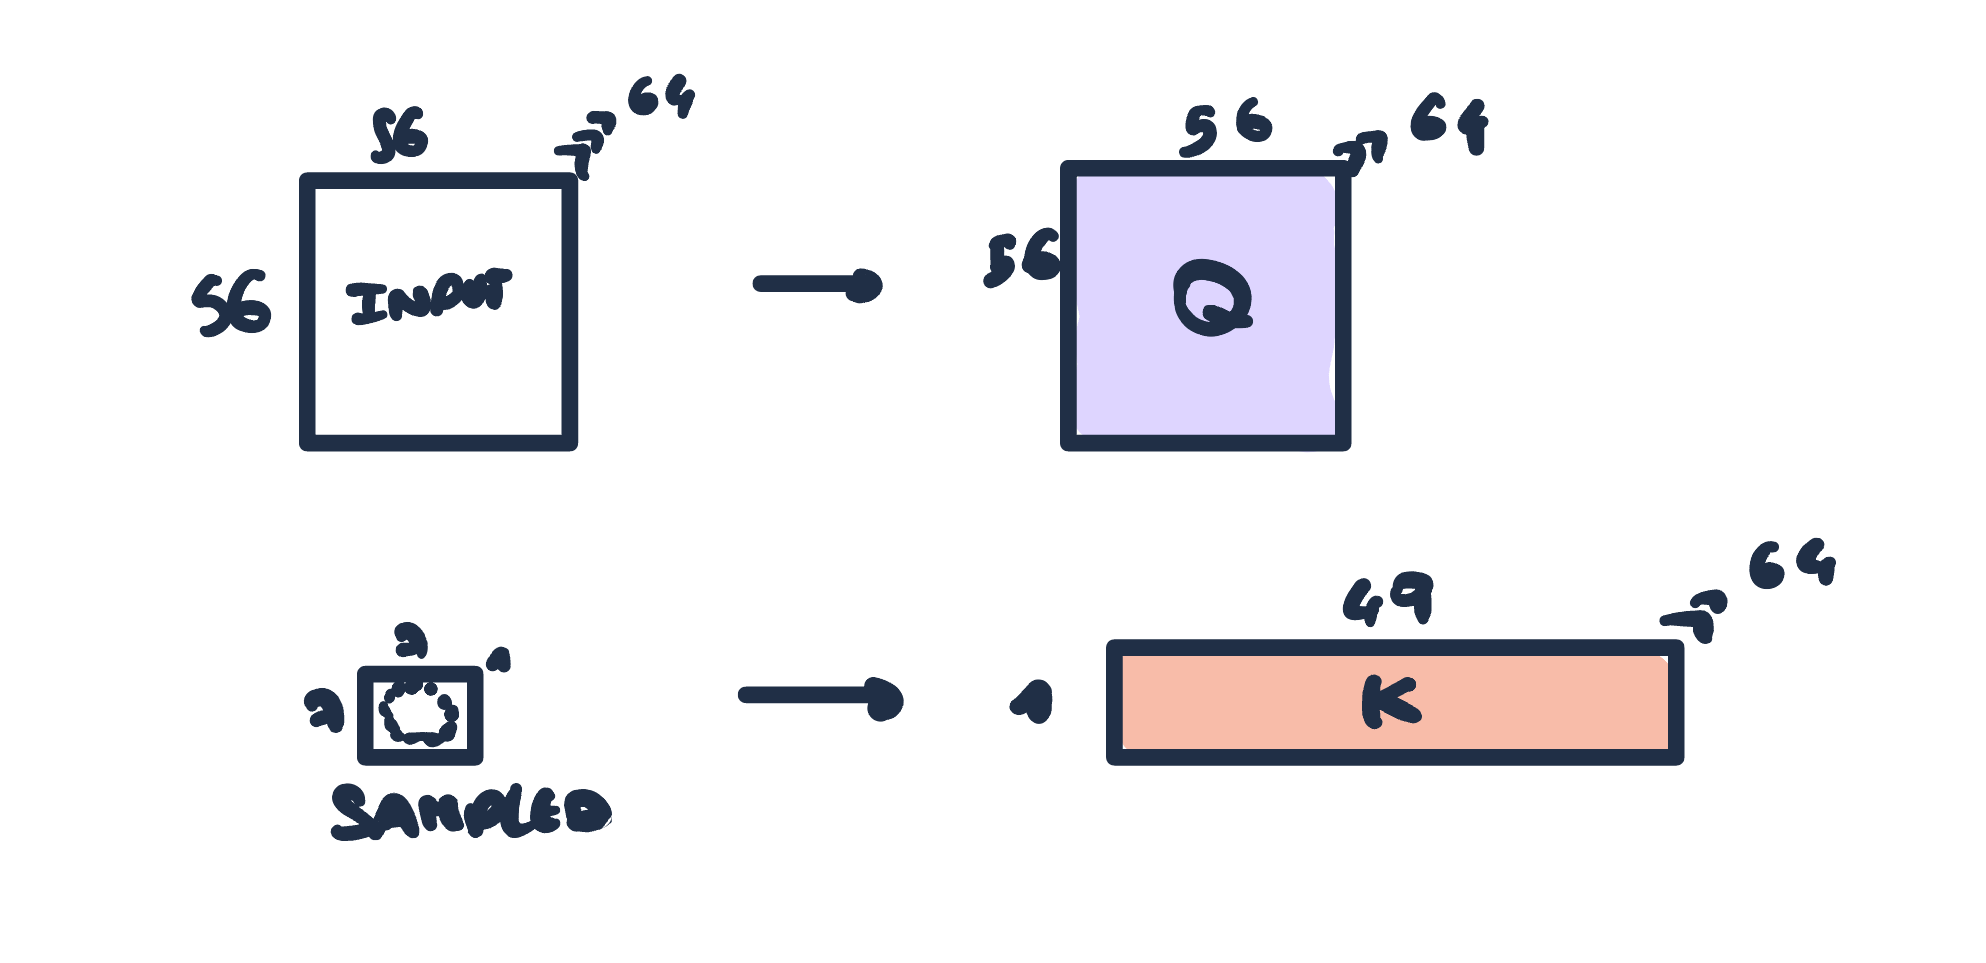

In a normal Transformer, the Key is coming from the input (it's also a duplicate), but not here, because we're doing the deformable thing. Now let's reshape everything to make the maths work.

In [ ]:
# we'll define some variables for convenience
n_sample = sampled_features.size()[-1]  # total number of keys
B, C, H, W = test_input_data.shape     # B =1, C = 64, H = 56, W = 56

In [ ]:
q = q.reshape(bs * n_heads, n_head_channels, H * W)
k = k.reshape(bs * n_heads, n_head_channels, n_sample)

print(f"Query shape = {q.shape}")
print(f"Key shape = {k.shape}")

Query shape = torch.Size([2, 32, 3136])
Key shape = torch.Size([2, 32, 49])


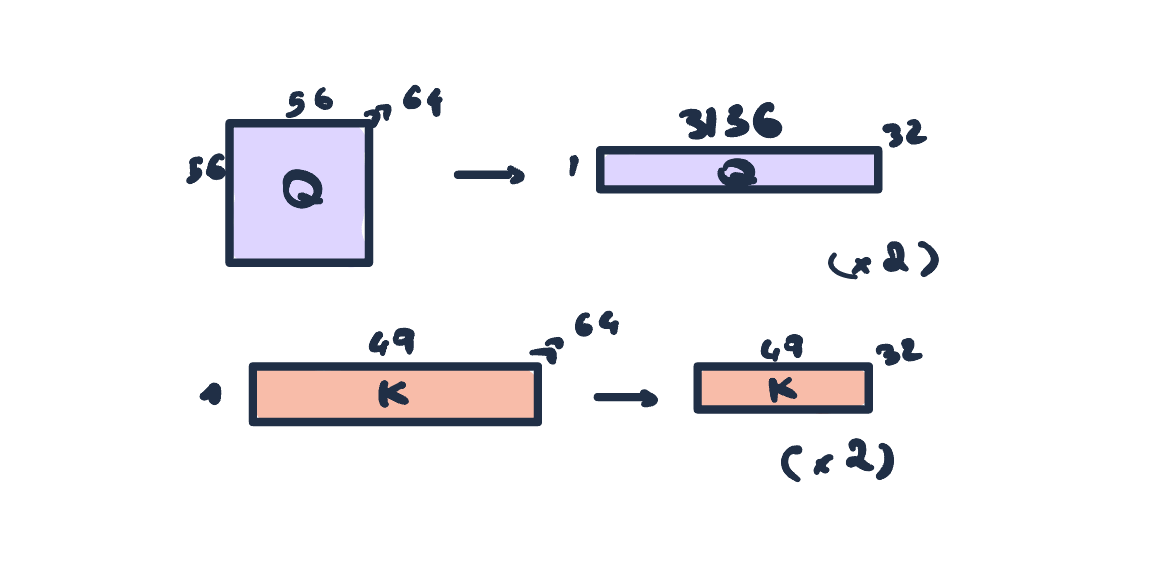

In [ ]:
# calculate attention, attn = (q * k) / root(n_head_channels)
attn = torch.einsum('b c m, b c n -> b m n', q, k)

scale = n_head_channels ** -0.5
attn = attn.mul(scale)
print(f"Attention shape = {attn.shape}")

Attention shape = torch.Size([2, 3136, 49])


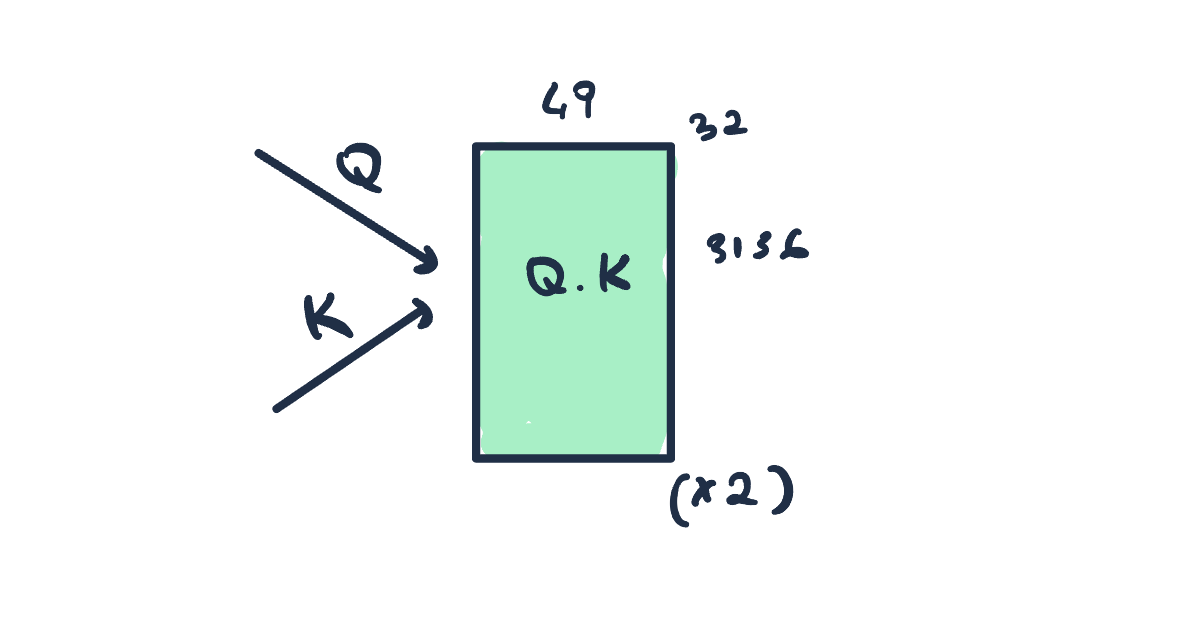

#### Relative Position Embedding

- There's one more additional detail, before we can use attention values.
- We used all grid points in the original vision transformer attention module. - But, here, as we're using only selected points, we're introducing a bias. So, we need a way to differentiate the position of these features (deformed keys).
- So, we use a variant of Position embedding for doing so.
- Effectively, we need to calculate relative positions of the sampled features w.r.t input feature map

We'll first calculate as grid for the query, very similar to reference grid function

In [ ]:
def get_query_grid(H, W, B):
    ref_y, ref_x = torch.meshgrid(
        torch.arange(0.0, H,),
        torch.arange(0.0, W),
        indexing='ij'
    )
    ref = torch.stack((ref_y, ref_x), -1)
    ref[..., 1].div_(W - 1.0).mul_(2.0).sub_(1.0)
    ref[..., 0].div_(H - 1.0).mul_(2.0).sub_(1.0)
    ref = ref[None, ...].expand(B * n_groups, -1, -1, -1) # B * g H W 2
    return ref

q_grid = get_query_grid(H, W, B)
print(f"Query grid shape = {q_grid.shape}")

Query grid shape = torch.Size([1, 56, 56, 2])


In [ ]:
# q_grid = (1, 56, 56, 2) -> (1, 56 * 56, 2) -> (1, 3136, 1, 2)
# pos = (1, 7, 7, 2) -> (1, 7 * 7, 2) -> (1, 1, 49, 2)
displacement = (q_grid.reshape(B * n_groups, H * W, 2).unsqueeze(2) - pos.reshape(B * n_groups, n_sample, 2).unsqueeze(1)).mul(0.5)
print(f"Displacement grid shape = {displacement.shape}")

Displacement grid shape = torch.Size([1, 3136, 49, 2])


The displacement matrix contains relative position of each key w.r.t each patch

In [ ]:
# create a position embedding in range [0, 111] as we're using centre of feature map as origin
rpe_table = nn.Parameter(torch.zeros(n_heads, q_size[0] * 2 - 1, q_size[1] * 2 - 1))
rpe_bias = rpe_table[None, ...].expand(B, -1, -1, -1)

attn_bias = F.grid_sample(
    input=rpe_bias,
    grid=displacement[..., (1, 0)],
    mode='bilinear', align_corners=True) # B * g, h_g, HW, Ns

attn_bias = attn_bias.reshape(B * n_heads, H * W, n_sample)
print(f"Attention bias shape = {attn_bias.shape}")

Attention bias shape = torch.Size([2, 3136, 49])


#### Adding the bias

In [ ]:
attn = attn + attn_bias
attn = F.softmax(attn, dim=2)
print(f"Attention shape = {attn.shape}")

Attention shape = torch.Size([2, 3136, 49])


#### Adding the value

In [ ]:
# calculate values using 1x1 conv, account for multiple heads
proj_v = nn.Conv2d(nc, nc, kernel_size=1, stride=1, padding=0)
v = proj_v(sampled_features).reshape(B * n_heads, n_head_channels, n_sample)
print(f"Values shape = {v.shape}")

Values shape = torch.Size([2, 32, 49])


In [ ]:
# output = attn * value
out = torch.einsum('b m n, b c n -> b c m', attn, v)
out = out.reshape(B, C, H, W)
print(f"DAT block output shape = {out.shape}")

DAT block output shape = torch.Size([1, 64, 56, 56])


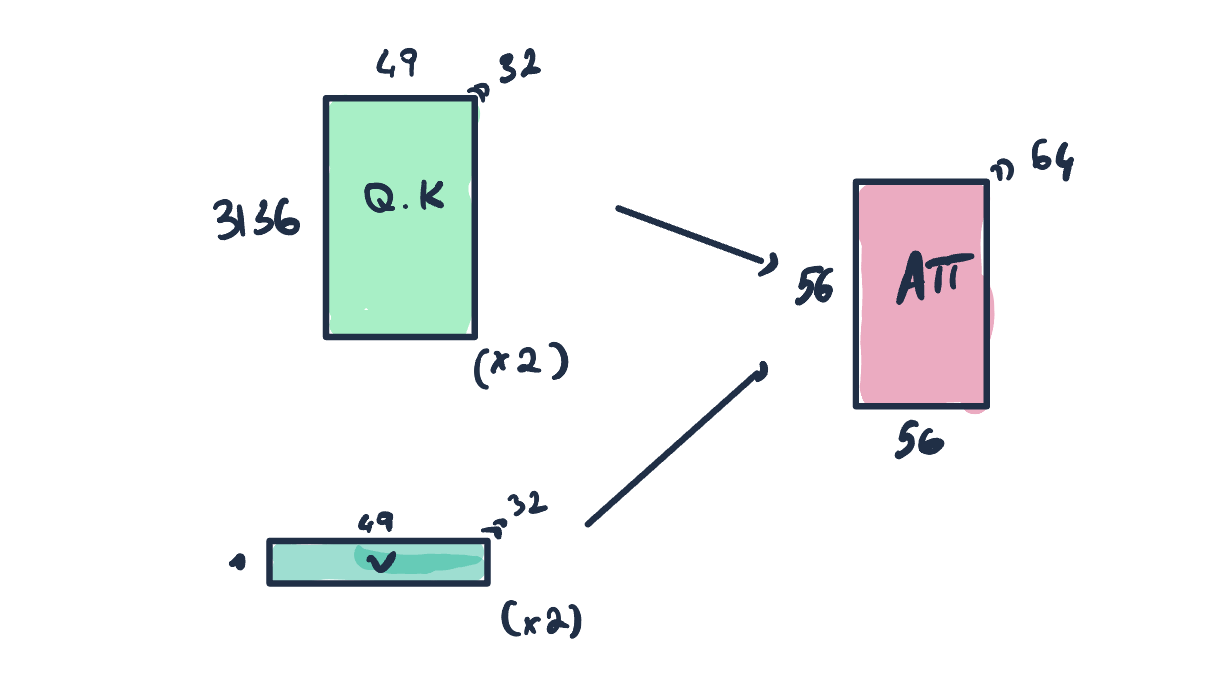

In this diagram, I skipped a part where one dimension is of size 3136 and we reshape it back to 56x56.<p>

So here we are!!! **Deformable Attention!**

### 5. Putting it altogether
Let's simply copy and paste everything we did into a single function we can call, the DAttention Baseline!

In [ ]:
class DAttentionBaseline(nn.Module):
    def __init__(self, q_size, n_heads, n_head_channels, n_groups,
            attn_drop, proj_drop, stride, ksize):
        super().__init__()
        self.n_head_channels = n_head_channels
        self.scale = self.n_head_channels ** -0.5
        self.n_heads = n_heads
        self.q_h, self.q_w = q_size
        self.kv_h, self.kv_w = self.q_h // stride, self.q_w // stride
        self.nc = n_head_channels * n_heads
        self.n_groups = n_groups
        self.n_group_channels = self.nc // self.n_groups
        self.n_group_heads = self.n_heads // self.n_groups
        self.ksize = ksize
        self.stride = stride
        kk = self.ksize
        pad_size = kk // 2 if kk != stride else 0

        self.conv_offset = nn.Sequential(
            nn.Conv2d(self.n_group_channels, self.n_group_channels, kk, stride, pad_size, groups=self.n_group_channels),
            LayerNormModule(self.n_group_channels),
            nn.GELU(),
            nn.Conv2d(self.n_group_channels, 2, 1, 1, 0, bias=False)
        )

        self.proj_q = nn.Conv2d(self.nc, self.nc, kernel_size=1, stride=1, padding=0)
        self.proj_k = nn.Conv2d(self.nc, self.nc, kernel_size=1, stride=1, padding=0)
        self.proj_v = nn.Conv2d(self.nc, self.nc, kernel_size=1, stride=1, padding=0)
        self.proj_out = nn.Conv2d(self.nc, self.nc, kernel_size=1, stride=1, padding=0)
        self.proj_drop = nn.Dropout(proj_drop, inplace=True)
        self.attn_drop = nn.Dropout(attn_drop, inplace=True)
        self.rpe_table = nn.Parameter(torch.zeros(self.n_heads, self.q_h * 2 - 1, self.q_w * 2 - 1))
        trunc_normal_(self.rpe_table, std=0.01)

    @torch.no_grad()
    def _get_ref_points(self, H_key, W_key, B, dtype, device):
        ref_y, ref_x = torch.meshgrid(
            torch.linspace(0.5, H_key - 0.5, H_key, dtype=dtype, device=device),
            torch.linspace(0.5, W_key - 0.5, W_key, dtype=dtype, device=device),
            indexing='ij'
        )
        ref = torch.stack((ref_y, ref_x), -1)
        ref[..., 1].div_(W_key - 1.0).mul_(2.0).sub_(1.0)
        ref[..., 0].div_(H_key - 1.0).mul_(2.0).sub_(1.0)
        ref = ref[None, ...].expand(B * self.n_groups, -1, -1, -1) # B * g H W 2

        return ref

    @torch.no_grad()
    def _get_q_grid(self, H, W, B, dtype, device):
        ref_y, ref_x = torch.meshgrid(
            torch.arange(0, H, dtype=dtype, device=device),
            torch.arange(0, W, dtype=dtype, device=device),
            indexing='ij'
        )
        ref = torch.stack((ref_y, ref_x), -1)
        ref[..., 1].div_(W - 1.0).mul_(2.0).sub_(1.0)
        ref[..., 0].div_(H - 1.0).mul_(2.0).sub_(1.0)
        ref = ref[None, ...].expand(B * self.n_groups, -1, -1, -1) # B * g H W 2
        return ref


    def forward(self, x):
        B, C, H, W = x.size()
        dtype, device = x.dtype, x.device

        q = self.proj_q(x)
        q_off = einops.rearrange(q, 'b (g c) h w -> (b g) c h w', g=self.n_groups, c=self.n_group_channels)
        offset = self.conv_offset(q_off).contiguous()  # B * g 2 Hg Wg
        Hk, Wk = offset.size(2), offset.size(3)
        n_sample = Hk * Wk


        offset = einops.rearrange(offset, 'b p h w -> b h w p')
        reference = self._get_ref_points(Hk, Wk, B, dtype, device)
        pos = (offset + reference).clamp(-1., +1.)

        x_sampled = F.grid_sample(
                input=x.reshape(B * self.n_groups, self.n_group_channels, H, W),
                grid=pos[..., (1, 0)], # y, x -> x, y
                mode='bilinear', align_corners=True) # B * g, Cg, Hg, Wg
        x_sampled = x_sampled.reshape(B, C, 1, n_sample)

        q = q.reshape(B * self.n_heads, self.n_head_channels, H * W)
        k = self.proj_k(x_sampled).reshape(B * self.n_heads, self.n_head_channels, n_sample)
        v = self.proj_v(x_sampled).reshape(B * self.n_heads, self.n_head_channels, n_sample)

        attn = torch.einsum('b c m, b c n -> b m n', q, k) # B * h, HW, Ns
        attn = attn.mul(self.scale)

        rpe_table = self.rpe_table
        rpe_bias = rpe_table[None, ...].expand(B, -1, -1, -1)
        q_grid = self._get_q_grid(H, W, B, dtype, device)
        displacement = (q_grid.reshape(B * self.n_groups, H * W, 2).unsqueeze(2) - pos.reshape(B * self.n_groups, n_sample, 2).unsqueeze(1)).mul(0.5)
        attn_bias = F.grid_sample(
            input=einops.rearrange(rpe_bias, 'b (g c) h w -> (b g) c h w', c=self.n_group_heads, g=self.n_groups),
            grid=displacement[..., (1, 0)],
            mode='bilinear', align_corners=True) # B * g, h_g, HW, Ns

        attn_bias = attn_bias.reshape(B * self.n_heads, H * W, n_sample)
        attn = attn + attn_bias

        attn = F.softmax(attn, dim=2)
        attn = self.attn_drop(attn)

        out = torch.einsum('b m n, b c n -> b c m', attn, v)
        out = out.reshape(B, C, H, W)
        y = self.proj_drop(self.proj_out(out))
        return y, pos.reshape(B, self.n_groups, Hk, Wk, 2)


In [ ]:
dat_module = DAttentionBaseline(q_size=(56, 56), n_heads=2, n_head_channels=32, n_groups=1, attn_drop=0,
                           proj_drop=0.0, stride=8, ksize=9)

# patch embedding output size = (1, 64, 56, 56)
# (bs, n_channels, feat_h, feat_w)
test_data = torch.Tensor(1, 64, 56, 56)
dat_module_output, deformed_points = dat_module(test_data)
print(dat_module_output.shape)
print(f"Deformed points = {[x.shape for x in deformed_points]}")

torch.Size([1, 64, 56, 56])
Deformed points = [torch.Size([1, 7, 7, 2])]


## II. Deformable Attention Transformer & Visualization

The Deformable Attention module, described in earlier section, is used as building block in **DAT** (Deformable Attention Transformer), whose architecture is as follows:

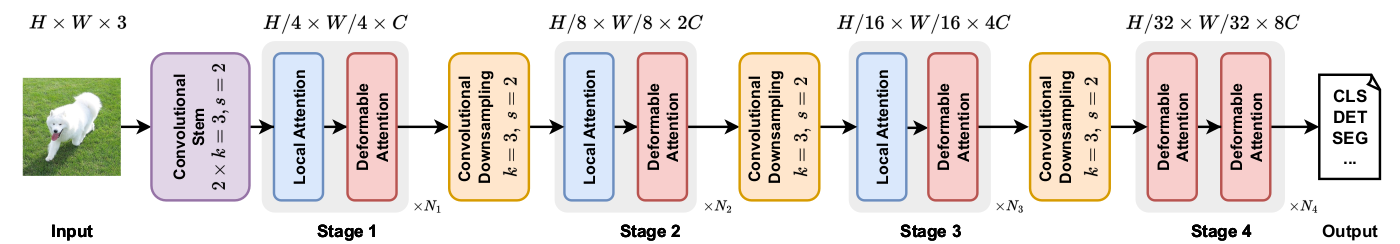

The complete model, uses another set of Local Attention (usually Neighbourhood attention, for example the Swin Transformer) in Transformer blocks. For now, we'll simply load a pretrained model.

### Calling the Model

In [ ]:
from dat import DAT
model = DAT()
print(model)

DAT(
  (patch_proj): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LayerNormProxy(
      (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
    (2): GELU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LayerNormProxy(
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (stages): ModuleList(
    (0): TransformerStage(
      (proj): Identity()
      (ln_cnvnxt): ModuleDict()
      (layer_norms): ModuleList(
        (0): LayerNormProxy(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): LayerNormProxy(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): LayerNormProxy(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (3): LayerNormProxy(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
      )
      (mlps):

Wait!!! The model is pretrained right? So we can finally use it on real images! Let's take a look!

rgb_image shape = (224, 224, 3), img shape = torch.Size([1, 3, 224, 224])


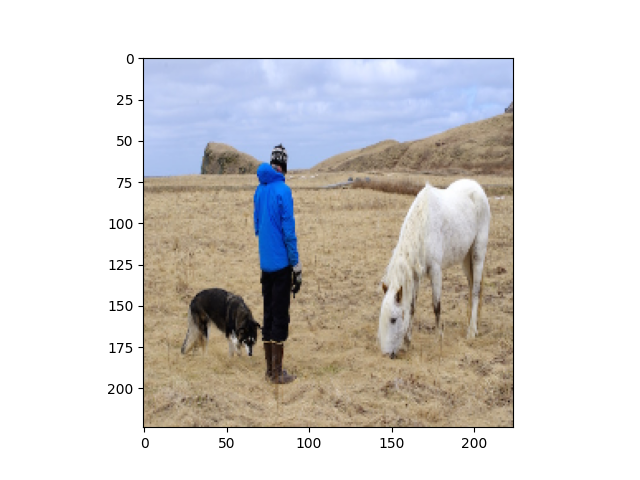

In [ ]:
from torchvision import transforms as pth_transforms
transform = pth_transforms.Compose([
        pth_transforms.ToTensor(),
        pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

def preprocess_image(image_path, reshape_size=(224, 224)):
    rgb_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    rgb_image = cv2.resize(rgb_image, reshape_size, interpolation=cv2.INTER_LINEAR)
    img = transform(rgb_image).unsqueeze(0)
    return rgb_image, img

plt.close()
rgb_image, img = preprocess_image('person.jpg')
print(f"rgb_image shape = {rgb_image.shape}, img shape = {img.shape}")
plt.imshow(rgb_image)
plt.show()

So THIS is what we'll calculate attention on! Ready?

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# change to evaluation mode and load pretrained model
model.eval();
model.to(device);
checkpoint = torch.load('fpn_dat_t_backbone.pth')
# checkpoint = torch.load('mrcn_dat_t_backbone.pth')
model.load_state_dict(checkpoint, strict=False)

_IncompatibleKeys(missing_keys=['cls_norm.norm.weight', 'cls_norm.norm.bias', 'cls_head.weight', 'cls_head.bias'], unexpected_keys=[])

Similar to Vision Transformer notebook, we'll define some helper functions and visualizer class to see output

In [ ]:
# get output from model
_, deformed_points = model(img)
last_stage_attention = model.stages[-1].attns[-1].attn.cpu().detach().numpy()
print(f"Last stage attention shape = {last_stage_attention.shape}")
print(f"Deformed points shape = {[x.shape for x in deformed_points]}")

last_stage_deformed_points = deformed_points[-1][0]
last_stage_deformed_points = einops.rearrange(last_stage_deformed_points, 'ng h w p -> ng (h w) p')
print(f"Last stage Deformed points shape = {last_stage_deformed_points.shape}")

Last stage attention shape = (16, 49, 49)
Deformed points shape = [(1, 1, 7, 7, 2), (1, 2, 7, 7, 2), (1, 2, 7, 7, 2), (1, 4, 7, 7, 2), (1, 4, 7, 7, 2), (1, 4, 7, 7, 2), (1, 4, 7, 7, 2), (1, 4, 7, 7, 2), (1, 4, 7, 7, 2), (1, 4, 7, 7, 2), (1, 4, 7, 7, 2), (1, 4, 7, 7, 2), (1, 8, 7, 7, 2), (1, 8, 7, 7, 2)]
Last stage Deformed points shape = (8, 49, 2)


So, in last stage, we have an attention output of (16, 49, 49), where
- 16 = batch_size * num_heads
- 49 = 7 * 7 = H_feat * W_feat = number of patches
- 49 = num_keys = number of deformed points

Deformed points shape = (8, 49, 2) where
- 8 = num of groups
- 49 = keys = deformed points
- 2 = x,y position

**NOTE** The deformed values are in [-1, 1] range

As we did in vision transformer, we'll select a patch in the image, see what is trying to attend to

### Visualizing Attention

In [ ]:
def get_model_attentions(model):
    from dat_blocks import DAttentionBaseline
    attns = []
    for s in range(len(model.stages)):
        num_attn_blocks = len(model.stages[s].attns)
        for n in range(num_attn_blocks):
            if(isinstance(model.stages[s].attns[n], DAttentionBaseline)):
                attn_i = model.stages[s].attns[n].attn.detach().cpu()
                attns.append(attn_i)
    return attns

In [ ]:
output_attentions = get_model_attentions(model)
print(f"Attentions shape for all stages = {[x.shape for x in output_attentions]}")

Attentions shape for all stages = [torch.Size([2, 3136, 49]), torch.Size([4, 784, 49]), torch.Size([4, 784, 49]), torch.Size([8, 196, 49]), torch.Size([8, 196, 49]), torch.Size([8, 196, 49]), torch.Size([8, 196, 49]), torch.Size([8, 196, 49]), torch.Size([8, 196, 49]), torch.Size([8, 196, 49]), torch.Size([8, 196, 49]), torch.Size([8, 196, 49]), torch.Size([16, 49, 49]), torch.Size([16, 49, 49])]


In [ ]:
def get_filtered_attention(attentions, deformed_points, n_top_scores = 5, query_pt = None):
    top_scores = []
    top_pts = []
    scale_factors = [4, 8, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 32, 32]

    for i in range(len(attentions)):
        # (num_head, num_patch, 49)
        attn_i = attentions[i]

        # specific query point is provided
        if query_pt is not None:
            patch_x = int(query_pt[0] / scale_factors[i])
            patch_y = int(query_pt[1] / scale_factors[i])
            patch_idx = patch_x * (224 // scale_factors[i]) + patch_y
            attn_i = torch.mean(attn_i, dim = 0)[patch_idx]
        # average across all query points
        else:
            attn_i = torch.mean(torch.sum(attn_i, dim =0), dim = 0)

        # attn_i shape = (49,)
        # for each stage, sort the attention scores and filter the top n scores
        attn_i = F.softmax(attn_i, dim =0)
        top_scores_i, top_indices_i = torch.sort(attn_i, descending = True)
        top_scores_i = top_scores_i.detach().cpu().numpy()[:n_top_scores]
        top_indices_i = top_indices_i.detach().cpu().numpy()[:n_top_scores]

        # filter points based on indices of top attention scores
        # convert from [-1,1] to image pixel coordinates
        # top_pts_i = (number of groups, n_top_scores, 2)
        deformed_pts_i = einops.rearrange(deformed_points[i][0], 'ng h w p -> ng (h w) p')
        top_pts_i = deformed_pts_i[:, top_indices_i, :]
        top_pts_i = np.clip((top_pts_i + 1) * 112, 0, 224)

        # repeating scores for number of groups
        # top_scores_i = (num_groups, n_top_scores)
        top_scores_i = np.expand_dims(top_scores_i, axis=0)
        top_scores_i = np.repeat(top_scores_i, deformed_pts_i.shape[0], axis=0)

        # storing results
        top_scores.append(top_scores_i)
        top_pts.append(top_pts_i)

    return top_scores, top_pts

In [ ]:
import numpy as np
import matplotlib.patches as patches
import IPython.display as Disp
from ipywidgets import Button, Layout

class Visualize_Deformable_Attention():
    def __init__(self, rgb_image, attention_maps, keys, figsize=(8,4), n_pts = 5):
        self.rgb_image = rgb_image
        self.attention_maps = attention_maps
        self.keys = keys
        self.n_pts = n_pts
        self.img_height, self.img_width, _ = self.rgb_image.shape

        # figure objects
        self.fig, axes = plt.subplots(1, 2, figsize=figsize)
        self.axes = axes.flatten()
        plt.suptitle('DEFORMABLE ATTENTION KEYPOINTS')
        self.fig.tight_layout()

        # RGB image
        for axes in self.axes:
            axes.imshow(self.rgb_image)
            axes.set(xticks=[], yticks=[])

        self.axes[0].set_title(f"Top {self.n_pts} keys with Attention scores")
        self.axes[1].set_title(f"Top {self.n_pts} keys for selected Query")

        # get top attention scores, averages across all pixels
        top_scores, top_pts = get_filtered_attention(self.attention_maps, self.keys, n_top_scores=self.n_pts)
        for i in range(len(top_scores)):
            self.axes[0].scatter(top_pts[i][:, :, 1], top_pts[i][:, :, 0], s = top_scores[i] * 2000, alpha = 0.5, color='orange')


        # triggers
        self.query_plot = None
        self.key_plots = []
        self.trigger = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        visualize_button = Button(description = "Visualize Attention Heads")
        Disp.display(visualize_button)
        visualize_button.on_click(self.plot_patch_attention)

    def plot_query_pt(self):
        if(self.query_plot is not None):
            self.query_plot.remove()
        self.query_plot = self.axes[1].scatter(self.query_pt[0], self.query_pt[1],
                             color = 'red', marker = '*', s =50)


    def onclick(self, event):
        if event.inaxes == self.axes[1]:
            self.query_pt = [event.xdata, event.ydata]
            self.plot_query_pt()

    def plot_patch_attention(self, _):
        self.axes[1].clear()
        self.axes[1].imshow(self.rgb_image)
        self.axes[1].set(xticks=[], yticks=[])
        self.axes[1].set_title(f"Top {self.n_pts} keys for selected Query")
        top_scores, top_pts = get_filtered_attention(self.attention_maps, self.keys, query_pt=self.query_pt)
        for i in range(len(top_scores)):
            self.axes[1].scatter(top_pts[i][:, :, 1], top_pts[i][:, :, 0], s = top_scores[i] * 2000, alpha = 0.3, color='yellow')
        self.plot_query_pt()

Button(description='Visualize Attention Heads', style=ButtonStyle())

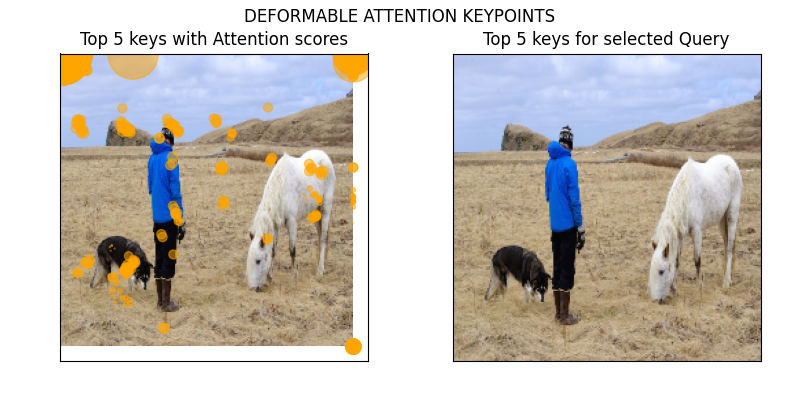

In [ ]:
%matplotlib ipympl
from google.colab import output
output.enable_custom_widget_manager()
visualizer = Visualize_Deformable_Attention(rgb_image, output_attentions, deformed_points)